In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv('./wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df = df.dropna(subset=['description', 'points'])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


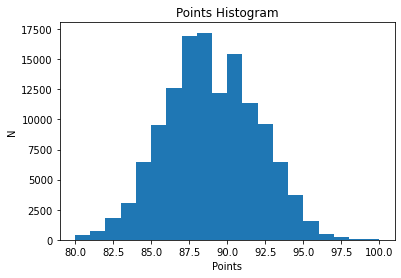

In [6]:
plt.hist(df.points, bins=20)
plt.title('Points Histogram')
plt.ylabel('N')
plt.xlabel('Points')
plt.show()

In [7]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "points", "label"]]

In [9]:
train, val, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

In [12]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [13]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + model

In [26]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [27]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.08069663, -0.32525516,  0.14281797, ..., -0.07206886,
         0.01328413, -0.11169718],
       [ 0.6647736 , -0.45134574,  0.13910915, ...,  0.11311597,
        -0.06679487,  0.00955806],
       [ 0.5920283 , -0.12149666, -0.11756155, ..., -0.02489159,
        -0.27980492, -0.04293557],
       ...,
       [ 0.38029492, -0.43431953, -0.10738443, ..., -0.0988437 ,
        -0.26011086,  0.15319142],
       [ 0.5899224 , -0.31429464, -0.00572118, ..., -0.13477047,
        -0.14340104, -0.05947853],
       [ 0.54837716,  0.03742255,  0.00320177, ..., -0.06771643,
         0.03821535,  0.13497815]], dtype=float32)>

In [28]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

In [32]:
model.evaluate(train_data)

102/102 [==============================] - 3s 28ms/step - loss: 0.7390 - accuracy: 0.3777


[0.738961935043335, 0.377702534198761]

In [33]:
model.evaluate(val_data)

13/13 [==============================] - 0s 26ms/step - loss: 0.7386 - accuracy: 0.3777


[0.7386361360549927, 0.377702534198761]

In [34]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
102/102 [==============================] - 104s 953ms/step - loss: 0.6789 - accuracy: 0.5708 - val_loss: 0.6129 - val_accuracy: 0.6304
Epoch 2/5
102/102 [==============================] - 89s 872ms/step - loss: 0.5323 - accuracy: 0.7392 - val_loss: 0.4108 - val_accuracy: 0.8162
Epoch 3/5
102/102 [==============================] - 96s 940ms/step - loss: 0.4211 - accuracy: 0.8228 - val_loss: 0.3762 - val_accuracy: 0.8297
Epoch 4/5
102/102 [==============================] - 68s 662ms/step - loss: 0.3805 - accuracy: 0.8440 - val_loss: 0.3669 - val_accuracy: 0.8327
Epoch 5/5
102/102 [==============================] - 67s 657ms/step - loss: 0.3537 - accuracy: 0.8575 - val_loss: 0.3669 - val_accuracy: 0.8323


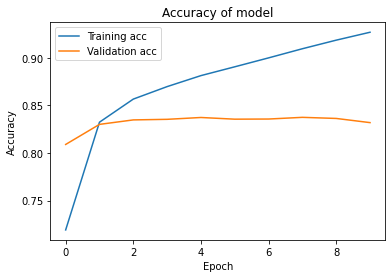

In [22]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

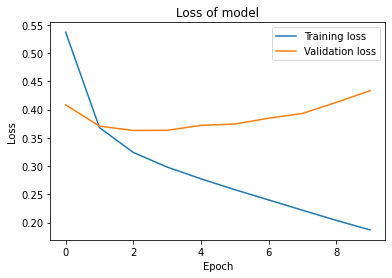

In [23]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [35]:
model.evaluate(test_data)

13/13 [==============================] - 2s 146ms/step - loss: 0.3705 - accuracy: 0.8306


[0.3704858124256134, 0.8305892944335938]

# LSTM

In [36]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [37]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [38]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True,
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

In [40]:
model.evaluate(train_data)
model.evaluate(val_data)

13/13 [==============================] - 3s 220ms/step - loss: 0.6929 - accuracy: 0.5426


[0.6929463148117065, 0.5425867438316345]

In [41]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
102/102 [==============================] - 75s 600ms/step - loss: 0.5325 - accuracy: 0.7222 - val_loss: 0.3734 - val_accuracy: 0.8280
Epoch 2/5
102/102 [==============================] - 58s 559ms/step - loss: 0.3616 - accuracy: 0.8389 - val_loss: 0.3574 - val_accuracy: 0.8393
Epoch 3/5
102/102 [==============================] - 60s 583ms/step - loss: 0.3464 - accuracy: 0.8465 - val_loss: 0.3503 - val_accuracy: 0.8410
Epoch 4/5
102/102 [==============================] - 69s 677ms/step - loss: 0.3400 - accuracy: 0.8491 - val_loss: 0.3512 - val_accuracy: 0.8391
Epoch 5/5
102/102 [==============================] - 79s 768ms/step - loss: 0.3371 - accuracy: 0.8497 - val_loss: 0.3497 - val_accuracy: 0.8433


In [42]:
model.evaluate(test_data)

13/13 [==============================] - 5s 382ms/step - loss: 0.3493 - accuracy: 0.8381


[0.34925684332847595, 0.8380520343780518]